In [1]:
!pip install transformers==4.41.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.0
    Uninstalling transformers-4.53.0:
      Successfully uninstalled transformers-4.53.0


In [2]:
import transformers
print(transformers.__version__)

4.41.0


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , f1_score,recall_score , precision_score
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import torchvision
from transformers.optimization import AdamW

In [4]:
# Load dataset
df = pd.read_csv("/content/phishing_site_urls.csv").dropna()

# Encode Labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
class_names = le.classes_

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class PhishingDataset(Dataset):
    def __init__(self, urls, labels, tokenizer, max_length):
        self.urls = urls
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        url = self.urls[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            url,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

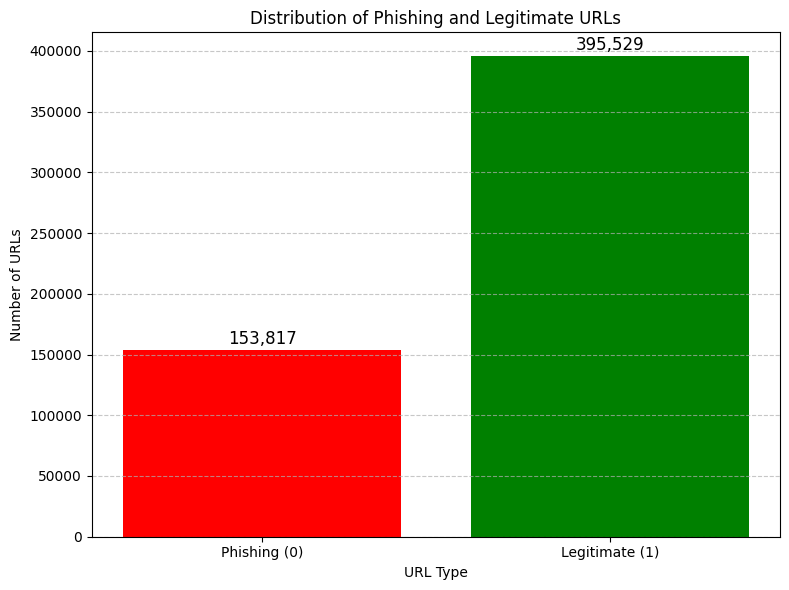

In [5]:


# Data
labels = ['Phishing (0)', 'Legitimate (1)']
counts = [153817, 395529]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['red', 'green'])
plt.title('Distribution of Phishing and Legitimate URLs')
plt.ylabel('Number of URLs')
plt.xlabel('URL Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate values
for i, count in enumerate(counts):
    plt.text(i, count + 5000, f'{count:,}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [6]:

# Split data
train_urls, test_urls, train_labels, test_labels = train_test_split(df['URL'], df['Label'], test_size=0.2, random_state=42)

# Create datasets
max_length = 64
train_dataset = PhishingDataset(train_urls.tolist(), train_labels.tolist(), tokenizer, max_length)
test_dataset = PhishingDataset(test_urls.tolist(), test_labels.tolist(), tokenizer, max_length)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# Load pre-trained DistilBERT model (base model to get embeddings)
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to('cuda')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [10]:
len(train_dataset)

439476

In [11]:
len(test_dataset)

109870

In [8]:
len(train_loader)

859

In [9]:
len(test_loader)

215

In [ ]:
# CNN Model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=tokenizer.pad_token_id)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=n_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, seq len]
        embedded = self.dropout(self.embedding(text).permute(0, 2, 1))
        # embedded = [batch size, embedding dim, seq len]
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        # conved[n] = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [F.max_pool1d(conv, conv.shape[-1]).squeeze(-1) for conv in conved]
        # pooled[n] = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        return self.fc(cat)

In [ ]:
# Initialize CNN model
cnn_embedding_dim = 128
cnn_n_filters = 100
cnn_filter_sizes = [3, 4, 5]
cnn_output_dim = 128 # Output dimension to match Transformer's output
cnn_dropout = 0.5
cnn_model = CNNModel(tokenizer.vocab_size, cnn_embedding_dim, cnn_n_filters, cnn_filter_sizes, cnn_output_dim, cnn_dropout).to('cuda')

In [ ]:
# Classification Layer
class CombinedModel(nn.Module):
    def __init__(self, distilbert_output_dim, cnn_output_dim, final_output_dim, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(distilbert_output_dim + cnn_output_dim, final_output_dim)

    def forward(self, distilbert_output, cnn_output):
        combined = torch.cat((distilbert_output, cnn_output), dim=-1)
        dropped = self.dropout(combined)
        return self.fc(dropped)


# nitialize Combined Model
distilbert_output_dim = distilbert_model.config.hidden_size
final_output_dim = 2 # Binary classification
combined_dropout = 0.3
combined_model = CombinedModel(distilbert_output_dim, cnn_output_dim, final_output_dim, combined_dropout).to('cuda')



In [ ]:
# Optimizer
optimizer = AdamW(list(distilbert_model.parameters()) + list(cnn_model.parameters()) + list(combined_model.parameters()), lr=5e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
def train_model(distilbert_model, cnn_model, combined_model, train_loader, optimizer, epochs):
    distilbert_model.train()
    cnn_model.train()
    combined_model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            optimizer.zero_grad()

            # Get DistilBERT embeddings (using the base model)
            distilbert_outputs = distilbert_model(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :] # Take the CLS token output

            # Get CNN output
            cnn_outputs = cnn_model(input_ids)

            # Combine outputs
            combined_outputs = combined_model(distilbert_outputs, cnn_outputs)

            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(combined_outputs, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

# Train the model
epochs = 3
train_model(distilbert_model, cnn_model, combined_model, train_loader, optimizer, epochs)

Epoch 1 Loss: 0.6333
Epoch 1 Loss: 1.2110
Epoch 1 Loss: 1.8127
Epoch 1 Loss: 2.3406
Epoch 1 Loss: 2.8560
Epoch 1 Loss: 3.2972
Epoch 1 Loss: 3.7075
Epoch 1 Loss: 4.0987
Epoch 1 Loss: 4.5062
Epoch 1 Loss: 4.7901
Epoch 1 Loss: 5.1151
Epoch 1 Loss: 5.4184
Epoch 1 Loss: 5.6888
Epoch 1 Loss: 5.9707
Epoch 1 Loss: 6.1802
Epoch 1 Loss: 6.4794
Epoch 1 Loss: 6.7185
Epoch 1 Loss: 6.8938
Epoch 1 Loss: 7.0934
Epoch 1 Loss: 7.2720
Epoch 1 Loss: 7.4779
Epoch 1 Loss: 7.6492
Epoch 1 Loss: 7.8680
Epoch 1 Loss: 8.0543
Epoch 1 Loss: 8.2098
Epoch 1 Loss: 8.3716
Epoch 1 Loss: 8.5933
Epoch 1 Loss: 8.7551
Epoch 1 Loss: 8.9269
Epoch 1 Loss: 9.0751
Epoch 1 Loss: 9.2516
Epoch 1 Loss: 9.3927
Epoch 1 Loss: 9.5774
Epoch 1 Loss: 9.7173
Epoch 1 Loss: 9.8156
Epoch 1 Loss: 9.9315
Epoch 1 Loss: 10.0356
Epoch 1 Loss: 10.1938
Epoch 1 Loss: 10.3130
Epoch 1 Loss: 10.4492
Epoch 1 Loss: 10.5683
Epoch 1 Loss: 10.6996
Epoch 1 Loss: 10.8208
Epoch 1 Loss: 10.9442
Epoch 1 Loss: 11.1135
Epoch 1 Loss: 11.2481
Epoch 1 Loss: 11.3402
Ep

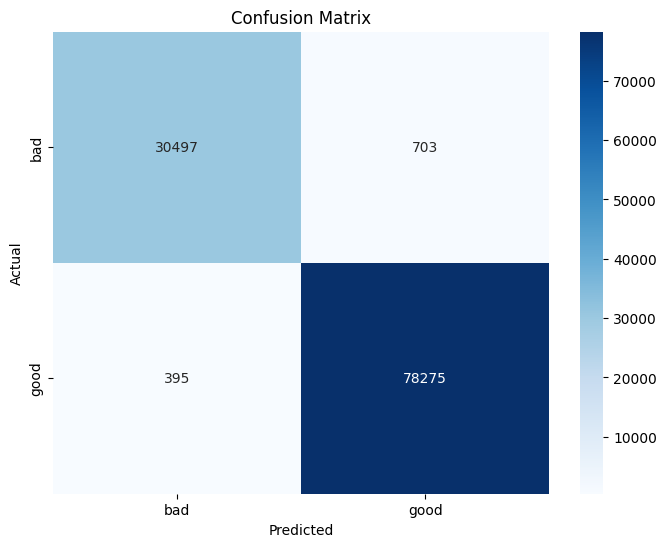


--- Overall Evaluation Metrics ---
Accuracy: 99.0006
Precision (Weighted): 0.9900
Recall (Weighted): 0.9900
F1-score (Weighted): 0.9900

----------------------------------

Classification Report (from sklearn):
              precision    recall  f1-score   support

         bad       0.99      0.98      0.98     31200
        good       0.99      0.99      0.99     78670

    accuracy                           0.99    109870
   macro avg       0.99      0.99      0.99    109870
weighted avg       0.99      0.99      0.99    109870



In [ ]:

def evaluate_model_with_visualization(distilbert_model, cnn_model, combined_model, test_loader, class_names):
    distilbert_model.eval()
    cnn_model.eval()
    combined_model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            # Get DistilBERT embeddings
            distilbert_outputs = distilbert_model(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

            # Get CNN output
            cnn_outputs = cnn_model(input_ids)

            # Combine outputs
            combined_outputs = combined_model(distilbert_outputs, cnn_outputs)

            _, predicted = torch.max(combined_outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Overall metrics using sklearn
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')  # 'weighted' averages over all labels
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print overall metrics
    print("\n--- Overall Evaluation Metrics ---")
    print(f"Accuracy: {accuracy*100:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-score (Weighted): {f1:.4f}")
    print("\n----------------------------------")

    # Print Classification Report
    print("\nClassification Report (from sklearn):")
    print(classification_report(all_labels, all_predictions, target_names=class_names))

# Evaluate the loaded model and visualize metrics
evaluate_model_with_visualization(distilbert_model, cnn_model, combined_model, test_loader, class_names)


In [ ]:
#################################################################### Individual CNN model###############################################################################

In [ ]:
from functools import total_ordering
class CNNForClassification(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, hidden_dim, output_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=n_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text).permute(0, 2, 1))
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[-1]).squeeze(-1) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        hidden = F.relu(self.fc1(cat))
        return self.fc2(hidden)

# Initialize this CNN model for individual training and evaluation
cnn_embedding_dim = 128
cnn_n_filters = 100
cnn_filter_sizes = [3, 4, 5]
cnn_hidden_dim = 64 # Added a hidden dimension
cnn_output_dim = 2
cnn_dropout = 0.5
cnn_pad_idx = tokenizer.pad_token_id
cnn_classification_model = CNNForClassification(tokenizer.vocab_size, cnn_embedding_dim, cnn_n_filters, cnn_filter_sizes, cnn_hidden_dim, cnn_output_dim, cnn_dropout, cnn_pad_idx).to('cuda')

# You would need to train this cnn_classification_model
criterion=nn.CrossEntropyLoss()
optimizer1=AdamW(cnn_classification_model.parameters(),lr=1e-4)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

def train(model, train_loader, optimizer1, criterion):
    model.train()
    for epoch in range(3):  # You can adjust the number of epochs
      total_loss = 0
      for batch in train_loader:
          input_ids = batch['input_ids'].to('cuda')
          labels = batch['labels'].to('cuda')
          optimizer1.zero_grad()
          outputs = model(input_ids)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer1.step()
          total_loss += loss.item()
          print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

train(cnn_classification_model, train_loader, optimizer1, criterion)

Epoch 1 Loss: 0.6101
Epoch 1 Loss: 1.2359
Epoch 1 Loss: 1.8678
Epoch 1 Loss: 2.4749
Epoch 1 Loss: 3.0882
Epoch 1 Loss: 3.6729
Epoch 1 Loss: 4.2783
Epoch 1 Loss: 4.8759
Epoch 1 Loss: 5.5054
Epoch 1 Loss: 6.1390
Epoch 1 Loss: 6.7498
Epoch 1 Loss: 7.3655
Epoch 1 Loss: 7.9666
Epoch 1 Loss: 8.5655
Epoch 1 Loss: 9.2065
Epoch 1 Loss: 9.8098
Epoch 1 Loss: 10.4200
Epoch 1 Loss: 11.0215
Epoch 1 Loss: 11.6427
Epoch 1 Loss: 12.2302
Epoch 1 Loss: 12.8541
Epoch 1 Loss: 13.4749
Epoch 1 Loss: 14.0954
Epoch 1 Loss: 14.6845
Epoch 1 Loss: 15.3192
Epoch 1 Loss: 15.9497
Epoch 1 Loss: 16.5300
Epoch 1 Loss: 17.1415
Epoch 1 Loss: 17.7459
Epoch 1 Loss: 18.3648
Epoch 1 Loss: 19.0098
Epoch 1 Loss: 19.5920
Epoch 1 Loss: 20.1926
Epoch 1 Loss: 20.8053
Epoch 1 Loss: 21.3946
Epoch 1 Loss: 21.9890
Epoch 1 Loss: 22.6094
Epoch 1 Loss: 23.2264
Epoch 1 Loss: 23.8055
Epoch 1 Loss: 24.3853
Epoch 1 Loss: 24.9705
Epoch 1 Loss: 25.5897
Epoch 1 Loss: 26.1899
Epoch 1 Loss: 26.7254
Epoch 1 Loss: 27.3352
Epoch 1 Loss: 27.9410
Epoc

Evaluation of CNN Model for Classification:
Accuracy: 92.8679
F1 Score: 0.9263
Precision: 0.9307
Recall: 0.9287
Confusion Matrix:
[[24431  6769]
 [ 1067 77603]]


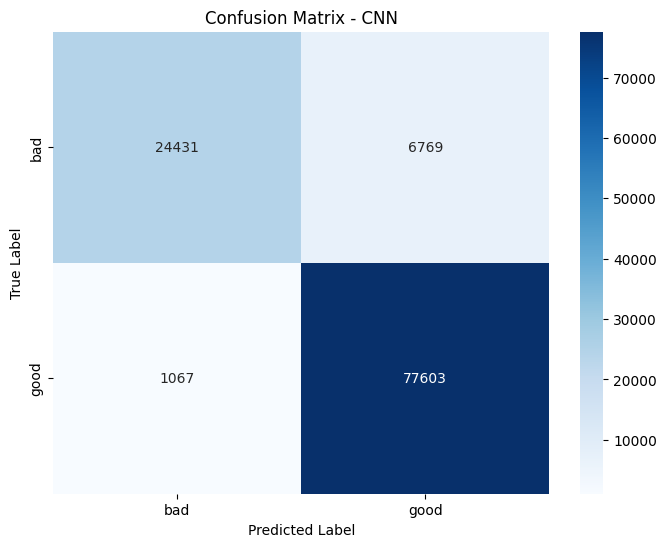

In [ ]:
def evaluate_cnn_model_explicit(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = model(input_ids)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print("Evaluation of CNN Model for Classification:")
    print(f'Accuracy: {accuracy*100:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('Confusion Matrix:')
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - CNN')
    plt.show()

evaluate_cnn_model_explicit(cnn_classification_model, test_loader)

In [ ]:
################################################################ Comparision with ML models###############################################################

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Model: LogisticRegression
Accuracy: 0.9042
F1 Score: 0.9355
Precision: 0.9032
Recall: 0.9703


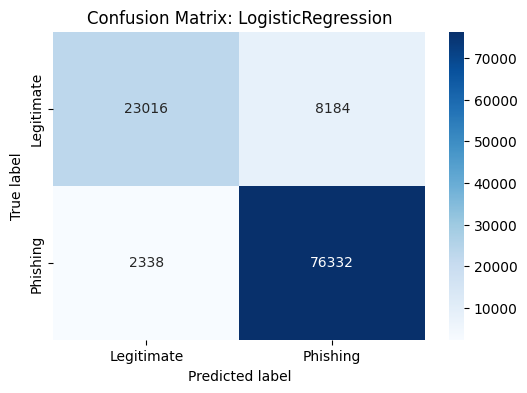

Model: DecisionTreeClassifier
Accuracy: 0.9173
F1 Score: 0.9440
Precision: 0.9170
Recall: 0.9726


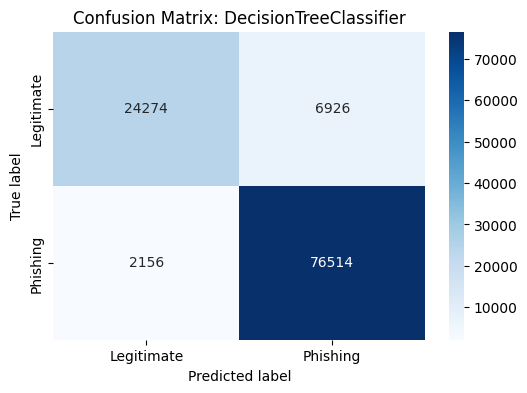

Model: RandomForestClassifier
Accuracy: 0.9216
F1 Score: 0.9470
Precision: 0.9185
Recall: 0.9773


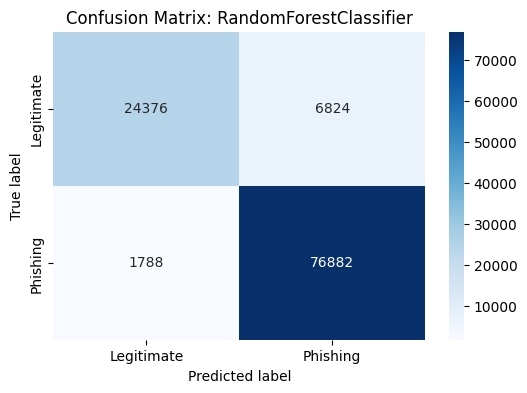

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:00:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBClassifier
Accuracy: 0.9034
F1 Score: 0.9348
Precision: 0.9049
Recall: 0.9667


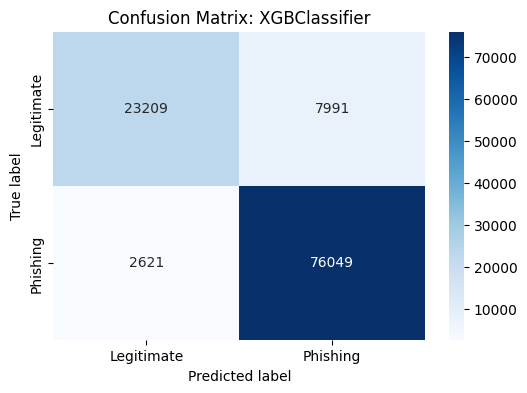

In [ ]:
df1=pd.read_csv("/content/phishing_site_urls.csv")


# Preprocessing: Convert URLs to numerical features using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df1['URL'])

# Target variable
y = df1['Label'].map({'good': 1, 'bad': 0})  # Assuming 'phishing' and 'legitimate' are the class labels

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Print evaluation metrics
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
    plt.title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# List of models to evaluate
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
]

# Evaluate each model
for model in models:
    evaluate_model(model, X_train, X_test, y_train, y_test)


In [ ]:
#######################################  Finish  ##############################